## Chapter 24 ARIMA Model for Forecasting

#### Autoregressive Integrated Moving Average Model

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.
- **AR: Autoregression**. A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I: Integrated**. The use of diﬀerencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) *in order to make the time series stationary*.
- **MA: Moving Average**. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of **ARIMA(p,d,q)** where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

- **p**: The number of lag observations included in the model, also called the lag order.
- **d**: The number of times that the raw observations are diﬀerenced, also called the degree of diﬀerencing.
- **q**: The size of the moving average window, also called the order of moving average.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual
errors of forecasts from the model.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
series = pd.read_csv('data/shampoo-sales.csv', index_col=0)
# baseline the year number on an arbitrary year (1900)
series.index = pd.to_datetime("190" + series.index.astype(str), format="%Y-%m")
series.head()

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


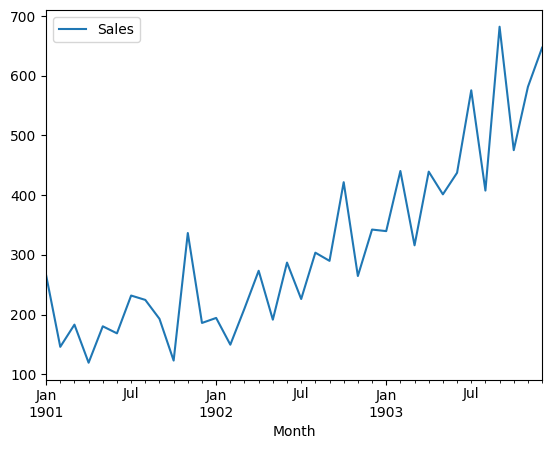

In [13]:
# line plot
series.plot()
plt.show()

We can see that the Shampoo Sales dataset has a clear trend. This suggests that the time series is not stationary and will require diﬀerencing to make it stationary, at least a diﬀerence order of 1. Let’s also take a quick look at an autocorrelation plot of the time series.

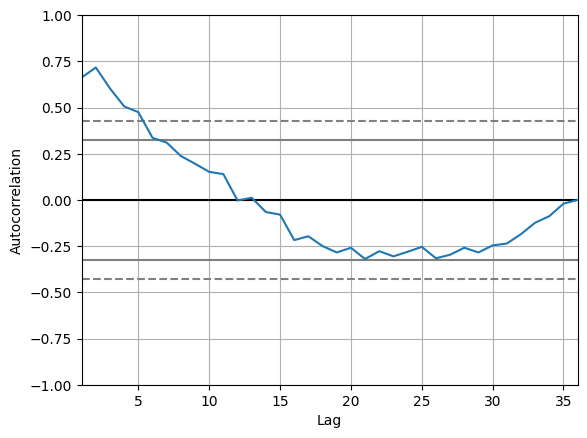

In [14]:
# autocorrelation plot of time series
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.show()

we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags. A good starting point for the AR parameter of the model may be 5.

#### ARIMA with Python

Let’s start oﬀ with something simple. We will fit an ARIMA model to the entire Shampoo Sales dataset and review the residual errors. First, we fit an `ARIMA(5,1,0)` model. This sets the lag value to 5 for autoregression, uses a diﬀerence order of 1 to make the time series stationary, and uses a moving average model of 0. When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this oﬀ by setting the `disp`
argument to 0.

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Wed, 08 Oct 2025   AIC                            408.969
Time:                        15:34:00   BIC                            418.301
Sample:                    01-01-1901   HQIC                           412.191
                         - 12-01-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.7

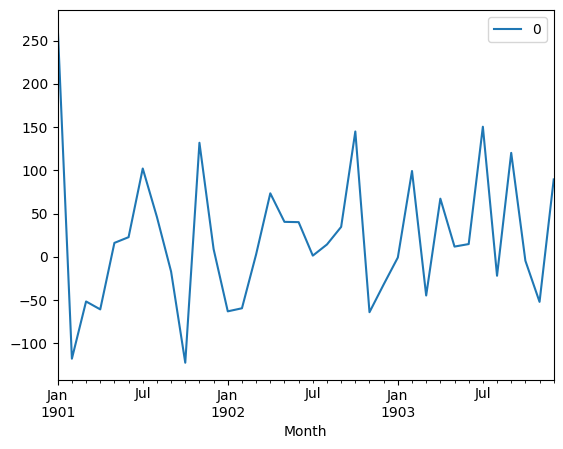

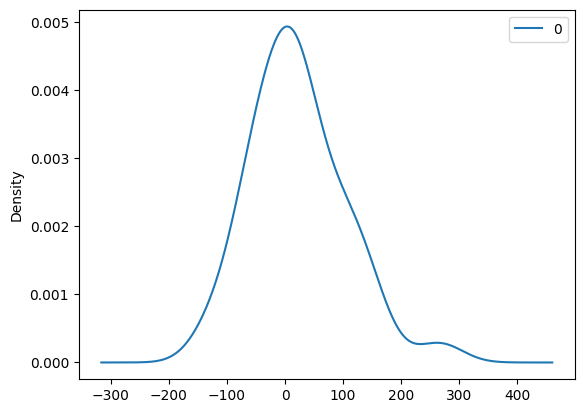

                0
count   36.000000
mean    21.936144
std     80.774430
min   -122.292030
25%    -35.040859
50%     13.147219
75%     68.848286
max    266.000000


In [29]:
# fit an ARIMA model and plot residual errors
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

Note, that although above we used the entire dataset for time series analysis, ideally we would perform this analysis on just the training dataset when developing a predictive model.

#### Rolling Forecast ARIMA Model

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for diﬀerencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received. We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

predicted=343.2721803001605, expected=342.3
predicted=293.329674034456, expected=339.7
predicted=368.6689556317312, expected=440.4
predicted=335.0447406535814, expected=315.9
predicted=363.2202215617436, expected=439.3
predicted=357.6453235815155, expected=401.3
predicted=443.04783521199016, expected=437.4
predicted=378.3656736493626, expected=575.5
predicted=459.41502093652883, expected=407.6
predicted=526.8908756895094, expected=682.0
predicted=457.231274249697, expected=475.3
predicted=672.9149435950784, expected=581.3
predicted=531.5414492920067, expected=646.9
Test RMSE: 89.021


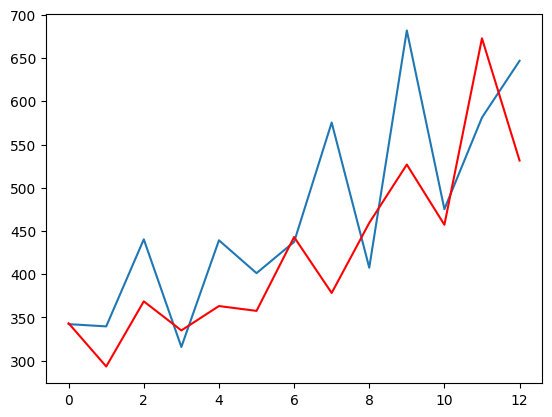

In [39]:
# evaluate an ARIMA model using a walk-forward validation
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
# split into train and test data
X = series['Sales'].values
size = int(len(X) * 0.66)
train, test = X[:size], X[size:]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
  model = ARIMA(history, order=(5,1,0))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  print(f'predicted={yhat}, expected={obs}')
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse:.3f}')
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()